In [1]:
#%pip install optuna
#%pip install catboost

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import xgboost
import lightgbm
import catboost

from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score as auc
from sklearn.preprocessing import MinMaxScaler,StandardScaler

import optuna


In [3]:
X_train =  pd.read_csv("..\\data\\train.csv")
X_test = pd.read_csv("..\\data\\test.csv")

In [4]:
X_train.head()

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,0,15674932,Okwudilichukwu,668,France,Male,33.0,3,0.00,2,1.0,0.0,181449.97,0
1,1,15749177,Okwudiliolisa,627,France,Male,33.0,1,0.00,2,1.0,1.0,49503.50,0
2,2,15694510,Hsueh,678,France,Male,40.0,10,0.00,2,1.0,0.0,184866.69,0
3,3,15741417,Kao,581,France,Male,34.0,2,148882.54,1,1.0,1.0,84560.88,0
4,4,15766172,Chiemenam,716,Spain,Male,33.0,5,0.00,2,1.0,1.0,15068.83,0


In [5]:
X_test.head()

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
0,165034,15773898,Lucchese,586,France,Female,23.0,2,0.00,2,0.0,1.0,160976.75
1,165035,15782418,Nott,683,France,Female,46.0,2,0.00,1,1.0,0.0,72549.27
2,165036,15807120,K?,656,France,Female,34.0,7,0.00,2,1.0,0.0,138882.09
3,165037,15808905,O'Donnell,681,France,Male,36.0,8,0.00,1,1.0,0.0,113931.57
4,165038,15607314,Higgins,752,Germany,Male,38.0,10,121263.62,1,1.0,0.0,139431.00


In [6]:
X_train.loc[:,'Geography'].unique()

array(['France', 'Spain', 'Germany'], dtype=object)

In [7]:
X_test.loc[:,'Geography'].unique()

array(['France', 'Germany', 'Spain'], dtype=object)

In [8]:
X_train.loc[:,'Gender'] = X_train.loc[:,'Gender'].map(lambda x: 1 if x=='Male' else 0)
X_test.loc[:,'Gender'] = X_test.loc[:,'Gender'].map(lambda x: 1 if x=='Male' else 0)

In [9]:
OE = OrdinalEncoder()
OE.fit(X_train.loc[:,'Geography'].values.reshape(-1,1))
X_train.loc[:,'Geography'] = OE.transform(X_train.loc[:,'Geography'].values.reshape(-1,1))
X_test.loc[:,'Geography'] = OE.transform(X_test.loc[:,'Geography'].values.reshape(-1,1))

In [10]:
X_train.head()

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,0,15674932,Okwudilichukwu,668,0.0,1,33.0,3,0.00,2,1.0,0.0,181449.97,0
1,1,15749177,Okwudiliolisa,627,0.0,1,33.0,1,0.00,2,1.0,1.0,49503.50,0
2,2,15694510,Hsueh,678,0.0,1,40.0,10,0.00,2,1.0,0.0,184866.69,0
3,3,15741417,Kao,581,0.0,1,34.0,2,148882.54,1,1.0,1.0,84560.88,0
4,4,15766172,Chiemenam,716,2.0,1,33.0,5,0.00,2,1.0,1.0,15068.83,0


In [11]:
convert_dict = {'Geography': int,
                'Gender': int
                }
 
X_train = X_train.astype(convert_dict)
X_test = X_test.astype(convert_dict)

In [12]:
x_train = X_train.drop_duplicates()
X_train = X_train.reset_index(drop=True)

In [13]:
print("Duplicates in Train Dataset: ",X_train.duplicated().sum())

Duplicates in Train Dataset:  0


In [14]:
X_train.loc[:,'IsSenior'] = X_train.loc[:,'Age'].apply(lambda x: 1 if x >= 60 else 0)
X_train.loc[:,'IsActive_by_CreditCard'] = X_train.loc[:, 'HasCrCard'] * X_train.loc[:,'IsActiveMember']
X_train.loc[:,'Products_Per_Tenure'] =  X_train.loc[:,'Tenure'] / X_train.loc[:,'NumOfProducts']

X_test.loc[:,'IsSenior'] = X_test.loc[:,'Age'].apply(lambda x: 1 if x >= 60 else 0)
X_test.loc[:,'IsActive_by_CreditCard'] = X_test.loc[:, 'HasCrCard'] * X_test.loc[:,'IsActiveMember']
X_test.loc[:,'Products_Per_Tenure'] =  X_test.loc[:,'Tenure'] / X_test.loc[:, 'NumOfProducts']

In [15]:
X_train.loc[:,'Surname_len'] = X_train.loc[:,'Surname'].apply(len)
X_test.loc[:,'Surname_len'] = X_test.loc[:,'Surname'].apply(len)

In [16]:
# features = ['CreditScore', 'Geography', "Gender", "Age" , "Tenure" , "Balance", "NumOfProducts", "HasCrCard", "IsActiveMember", 'EstimatedSalary']
features = ['CreditScore', 'Geography', "Gender", "Age" , "Tenure" , "NumOfProducts", "HasCrCard", "IsActiveMember", 'EstimatedSalary', "IsSenior","IsActive_by_CreditCard" , "Products_Per_Tenure", 'Surname_len']

In [17]:
X_train.isnull().sum(axis=0)

id                        0
CustomerId                0
Surname                   0
CreditScore               0
Geography                 0
Gender                    0
Age                       0
Tenure                    0
Balance                   0
NumOfProducts             0
HasCrCard                 0
IsActiveMember            0
EstimatedSalary           0
Exited                    0
IsSenior                  0
IsActive_by_CreditCard    0
Products_Per_Tenure       0
Surname_len               0
dtype: int64

In [18]:
X_train.head()

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,IsSenior,IsActive_by_CreditCard,Products_Per_Tenure,Surname_len
0,0,15674932,Okwudilichukwu,668,0,1,33.0,3,0.00,2,1.0,0.0,181449.97,0,0,0.0,1.5,14
1,1,15749177,Okwudiliolisa,627,0,1,33.0,1,0.00,2,1.0,1.0,49503.50,0,0,1.0,0.5,13
2,2,15694510,Hsueh,678,0,1,40.0,10,0.00,2,1.0,0.0,184866.69,0,0,0.0,5.0,5
3,3,15741417,Kao,581,0,1,34.0,2,148882.54,1,1.0,1.0,84560.88,0,0,1.0,2.0,3
4,4,15766172,Chiemenam,716,2,1,33.0,5,0.00,2,1.0,1.0,15068.83,0,0,1.0,2.5,9


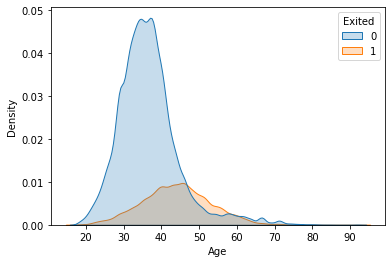

In [19]:
sns.kdeplot(data=X_train, x='Age', fill=True, hue='Exited' )
plt.show()

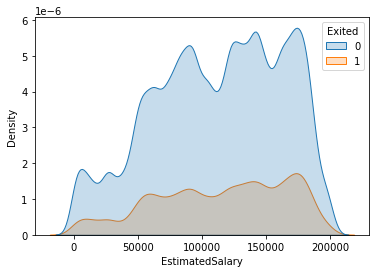

In [19]:
sns.kdeplot(data=X_train, x='EstimatedSalary', fill=True, hue='Exited' )
plt.show()

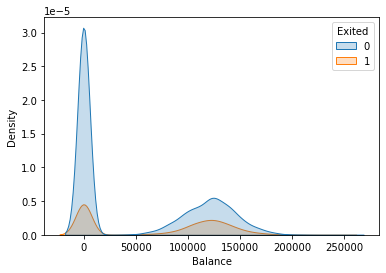

In [20]:
sns.kdeplot(data=X_train, x='Balance', fill=True, hue='Exited' )
plt.show()

In [21]:
print(f"Balance==0 %: {X_train.loc[X_train['Balance']==0,:].shape[0]/X_train.shape[0]}")
print(f"Balance==0 and Exited==0 : {X_train.loc[(X_train['Balance']==0) & (X_train['Exited']==1),:].shape[0]/X_train.loc[X_train['Balance']==0,:].shape[0]}")
print(f"Balance~=0 and Exited==0 : {X_train.loc[(X_train['Balance']!=0) & (X_train['Exited']==1),:].shape[0]/X_train.loc[X_train['Balance']!=0,:].shape[0]}")

Balance==0 %: 0.5432092780881516
Balance==0 and Exited==0 : 0.161654470819204
Balance~=0 and Exited==0 : 0.27099196137213805


In [22]:
L2=list(set(X_test.Surname.unique())-set(X_train.Surname.unique()))
print(len(L2))

92


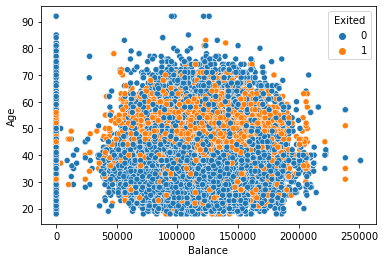

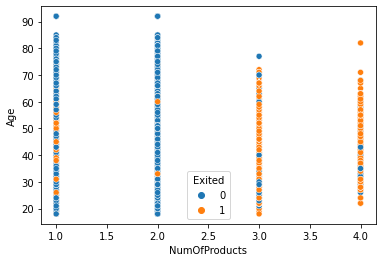

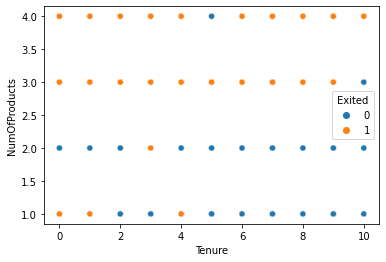

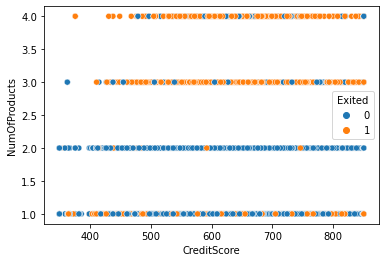

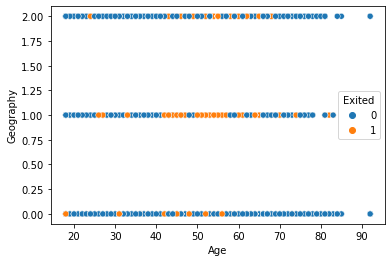

In [25]:
sns.scatterplot(data=X_train, x='Balance', y="Age",hue='Exited')
plt.show()
sns.scatterplot(data=X_train, x='NumOfProducts', y="Age",hue='Exited')
plt.show()
sns.scatterplot(data=X_train, x='Tenure', y="NumOfProducts",hue='Exited')
plt.show()
sns.scatterplot(data=X_train, x='CreditScore', y="NumOfProducts",hue='Exited')
plt.show()
sns.scatterplot(data=X_train, x='Age', y="Geography",hue='Exited')
plt.show()

In [26]:
# Stritified Cross Validation by 5 Folds using day of week as a target

KFOLD = 5
X_train.loc[:, 'fold'] = 0
skf = StratifiedKFold(n_splits = KFOLD, random_state=42, shuffle=True)
for fold, (tr_idx, val_idx) in enumerate(skf.split(X_train.loc[:, features], X_train.loc[:, 'Exited'])) :
    print(f"Fold {fold}...")
    X_train.loc[val_idx,'fold'] = fold


Fold 0...
Fold 1...
Fold 2...
Fold 3...
Fold 4...


In [37]:
from sklearn.ensemble import RandomForestClassifier

SCALER=False
scaler_type='mm'

class TrainModel:
    
    def __init__(self, X_train, X_test, MODEL, features):
        self.X_train = X_train
        self.X_test = X_test
        self.MODEL = MODEL
        self.features = features
        self.selected_features = features.copy()
        self.param = None
        self.model=None
        self.new_train = X_train.copy()
        self.auc_OOF= None
        self.auc_test = None
        
    def reset_features(self):
        self.selected_features = self.features.copy()
    def reset_data(self):
        self.new_train = X_train.copy()
        self.X_test = X_test
    
    def update_features(self, f_to_eliminate):
        for f in f_to_eliminate:
            self.selected_features.remove(f)
    def model_scaler(self,scaler_type):
        data = self.new_train.loc[:, self.selected_features]
        if scaler_type=='mm':
            scaler = MinMaxScaler()
        if scaler_type =='ss':
            scaler=StandardScaler()
            
        scaler.fit(data)
        self.new_train.loc[:, self.selected_features] = scaler.transform(self.new_train.loc[:, self.selected_features])
        self.X_test.loc[:, self.selected_features] = scaler.transform(self.X_test.loc[:, self.selected_features])
        
    def get_model(self,param):
        if self.MODEL=='rf':

            rf = RandomForestClassifier().set_params(**param)
            return rf
        if self.MODEL=='xgb':
            xgb = xgboost.XGBClassifier(**param)
            return xgb

        if self.MODEL=='lgbm':
            lgb = lightgbm.LGBMClassifier(**param)
            return lgb
        if self.MODEL=='cat':
            cat = catboost.CatBoostClassifier().set_params(**param)
            return cat
    
    def model_train(self, PRINT,SCALER):
        TEST_PRED = []
        param = self.param
        if SCALER:
            self.model_scaler(scaler_type)
        for fold in range(KFOLD):
            if PRINT:
                print(f"fold: {fold}.........")
            X = self.new_train.loc[self.new_train.fold!=fold, self.selected_features]
            y = self.new_train.loc[self.new_train.fold!=fold, 'Exited']

            X_val = self.new_train.loc[self.new_train.fold==fold, self.selected_features]
            y_val = self.new_train.loc[self.new_train.fold==fold,'Exited']
            if PRINT:
                print('Load model.....')
            model = self.get_model(param)
            if PRINT:
                print('model fitting......')
            model.fit(X,y)
            train_pred = model.predict_proba(X)[:,1]
            
            val_pred = model.predict_proba(X_val)[:,1]
            
            self.new_train.loc[self.new_train.fold==fold, 'pred'] = val_pred
#             self.new_train.loc[(self.new_train.fold==fold) & (self.new_train.status==0), 'pred'] = 1-self.new_train.loc[(self.new_train.fold==fold) & (self.new_train.status==0), 'pred']
            test_pp = model.predict_proba(self.X_test.loc[:, self.selected_features])[:,1]
#             test_pp[self.X_test.status==0]=1-test_pp[self.X_test.status==0]
            TEST_PRED.append(test_pp)
            if PRINT:
                print(f"training auc score: {auc(y, train_pred)}")
                print(f"validation infold auc score: {auc(y_val, val_pred)}")
                print("--"*30)

        if PRINT:
            print("=="*30)
        
        test_pred = np.mean(TEST_PRED, axis=0)
        self.X_test.loc[:,'pred'] = test_pred
        
        self.model = model
        if PRINT:
#             
            print(f"validation OOF auc score: {auc(self.new_train.loc[:,'Exited'], self.new_train.loc[:,'pred'])}")
#             print(f"test auc score:{auc(self.X_test.loc[:,'Exited'], self.X_test.loc[:,'pred'] )}")
        self.auc_OOF = auc(self.new_train.loc[:,'Exited'], self.new_train.loc[:,'pred'])
#         self.auc_test = self.model, auc(self.X_test.loc[:,'Exited'], self.X_test.loc[:,'pred'] )
            
        return auc(self.new_train.loc[:,'Exited'], self.new_train.loc[:,'pred']), self.model#, auc(self.X_test.loc[:,'Exited'], self.X_test.loc[:,'pred'] )

    
    def fit_model(self,param):
        self.new_train.loc[:, 'pred']=0.0
        if SCALER:
            self.model_scaler(scaler_type)

        for fold in range(KFOLD):

            X = self.new_train.loc[self.new_train.fold!=fold, self.selected_features]
            y = self.new_train.loc[self.new_train.fold!=fold, 'Exited']

            X_val = self.new_train.loc[self.new_train.fold==fold, self.selected_features]
            y_val = self.new_train.loc[self.new_train.fold==fold,'Exited']
            model = self.get_model(param)
            model.fit(X,y)
            train_pred = model.predict_proba(X)[:,1]
            val_pred = model.predict_proba(X_val)[:,1]
            self.new_train.loc[self.new_train.fold==fold, 'pred'] = val_pred
#             self.new_train.loc[(self.new_train.fold==fold) & (self.new_train.status==0), 'pred'] = 1-self.new_train.loc[(self.new_train.fold==fold) & (self.new_train.status==0), 'pred']




        return auc(self.new_train.loc[:,'Exited'], self.new_train.loc[:,'pred'])
    
    
    def objective(self, trial):  
    
        r = self.new_train.loc[self.new_train['Exited']==0,:].shape[0]/self.new_train.shape[0]
        class_weight= {'0':1-r, '1':r}


        if self.MODEL=='rf':
            # Random Forest Parameters

            param = {"n_estimators":  trial.suggest_categorical('n_estimators', [20, 50, 100, 200, 300, 400, 600]),
                 "max_depth": trial.suggest_categorical('max_depth', [10,20,30,40,50,60,70,80,90]),
                 "min_samples_split": trial.suggest_categorical('min_samples_split', [2, 5, 10]),
                 "min_samples_leaf": trial.suggest_categorical('min_samples_leaf', [1,2,4]),
                 "random_state": trial.suggest_categorical('random_state', [42]),
                 "class_weight": trial.suggest_categorical('class_weight', ['balanced'])

            } 


        if self.MODEL == 'xgb':
              # xgb Parameters
            param={
                'tree_method':'hist',
                'device' : "cuda",
#             'objective': trial.suggest_categorical('objective',['multi:softmax']),
                'objective': trial.suggest_categorical('objective',['binary:logistic']),

#             'eval_metric': trial.suggest_categorical('eval_metric',['mlogloss']),
#                 'num_class': trial.suggest_categorical('num_class',[2]),
            'eval_metric': trial.suggest_categorical('eval_metric',['auc']),
            'lambda': trial.suggest_float('lambda', 1e-3, 10.0, log=True),
            'alpha': trial.suggest_float('alpha', 1e-3, 10.0, log=True),
            'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.3,0.4,0.5,0.6,0.7,0.8,0.9, 1.0]),
            'subsample': trial.suggest_categorical('subsample', [0.4,0.5,0.6,0.7,0.8,1.0]),
            'learning_rate': trial.suggest_categorical('learning_rate', [0.008,0.009,0.01,0.012,0.014,0.016,0.018, 0.02]),
            'n_estimators': trial.suggest_categorical('n_estimators', [300, 400, 600, 800, 1000]),
            'max_depth': trial.suggest_categorical('max_depth', [10,20,30,40,50,60,70,80]),
            'min_child_weight': trial.suggest_int('min_child_weight', 1, 300),
    #             'scale_pos_weight': trial.suggest_categorical('scale_pos_weight',[r, 1.2*r, 1.5*r , 2*r, 2.5*r]),
    #             'sample_weight': trial.suggest_categorical('sample_weight',[list(class_weight.values())]),
    #              'early_stopping_rounds': trial.suggest_categorical('early_stopping_rounds', [10]),

                }
        if self.MODEL == 'lgbm':

            param = {
                    'objective': trial.suggest_categorical('objective',['binary']), 
                    'metric': trial.suggest_categorical('metric',['auc']), 
                    'device': trial.suggest_categorical('device',['gpu']),
                    'boosting': trial.suggest_categorical('boosting',['goss']),
                    'learning_rate': trial.suggest_categorical('learning_rate', [0.008,0.009,0.01,0.012,0.014,0.016,0.018, 0.02]),
                    'num_leaves': 8,
                    'feature_fraction': trial.suggest_categorical('feature_fraction', [0.3,0.4,0.5,0.6,0.7,0.8,0.9, 1.0]),
                    'bagging_fraction': trial.suggest_categorical('bagging_fraction', [0.3,0.4,0.5,0.6,0.7,0.8,0.9, 1.0]),
                    'lambda_l1': trial.suggest_float('lambda_l1', 1e-3, 10.0, log=True), 
                    'lambda_l2': trial.suggest_float('lambda_l2', 1e-3, 10.0, log=True),
                    'n_jobs': trial.suggest_categorical('n_jobs',[-1]),
                    'is_unbalance':trial.suggest_categorical('is_unbalance',[True]), 
                    'verbose': trial.suggest_categorical('verbose',[-1]),
                    'seed': trial.suggest_categorical('seed',[42]),
                    }

        if self.MODEL == 'cat':
              
            param = {
                    'learning_rate': trial.suggest_float("learning_rate", 0.001, 0.01, step=0.003), 
                    'depth': trial.suggest_int('depth', 5, 11), 
                    'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1.0, 5.0, step=0.5),
                    "min_child_samples": trial.suggest_categorical('min_child_samples', [1, 4, 8, 16, 32]),
                    'grow_policy': trial.suggest_categorical('grow_policy', ["Depthwise"]),
                    "iterations": trial.suggest_categorical('iterations', [300, 400, 600, 800, 1000]),
                    "task_type":trial.suggest_categorical("task_type",["GPU"]),
#                     "use_best_model": trial.suggest_categorical('use_best_model', [True]),
#                     "eval_metric": trial.suggest_categorical('eval_metric', ['AUC']),
                    "od_type": trial.suggest_categorical('od_type', ['Iter']),
                    "od_wait": trial.suggest_categorical('od_wait', [50]),
                    "random_state": trial.suggest_categorical('random_state', [42]),
                    "logging_level": trial.suggest_categorical('logging_level', ['Silent']),
                    }



        return self.fit_model(param)

    
    def get_best_param(self, N_TRIALS):
    #     optuna.logging.set_verbosity(optuna.logging.WARNING)
        study=optuna.create_study(direction='maximize')
        study.optimize(self.objective , n_trials=N_TRIALS)
        print('Number of finished trials:', len(study.trials))
        print('Best trial:', study.best_trial.params)
        print(f"Best trial Score: {study.best_trial.value}")
        self.param = study.best_trial.params

In [28]:
N_TRAILS=30
xgb1 = TrainModel(X_train,X_test, 'xgb', features)


# xgb1.get_best_param(N_TRAILS)

In [29]:
best_param_xgb = {'objective': 'binary:logistic', 'tree_method':'hist','device' : 'cuda' , 'eval_metric': 'auc', 'lambda': 0.1609974700699936, 'alpha': 8.00150841553724, 'colsample_bytree': 0.6, 'subsample': 1.0, 'learning_rate': 0.009, 'n_estimators': 1000, 'max_depth': 70, 'min_child_weight': 87}
xgb1.param = best_param_xgb
xgb_auc_OOF, xgb_model = xgb1.model_train(True, SCALER)

fold: 0.........
Load model.....
model fitting......
[08:34:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "device" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


training auc score: 0.8883099641115365
validation infold auc score: 0.8790207927571693
------------------------------------------------------------
fold: 1.........
Load model.....
model fitting......
[08:35:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "device" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  b

In [30]:
imp_df = pd.DataFrame({'features':features,'imp':xgb_model.feature_importances_})
imp_df.sort_values('imp', ascending=False, inplace=True)
imp_df.head(n=30)

,features,imp
5,NumOfProducts,0.546417
7,IsActiveMember,0.150511
3,Age,0.094128
10,IsActive_by_CreditCard,0.074260
9,IsSenior,0.044469
2,Gender,0.034800
1,Geography,0.023037
11,Products_Per_Tenure,0.014045
6,HasCrCard,0.006894
4,Tenure,0.005647


In [38]:
results_train = pd.DataFrame()
results_test = pd.DataFrame()

results_train.loc[:,'id'] = xgb1.new_train.loc[:,'id']
results_train.loc[:,'Exited'] = xgb1.new_train.loc[:,'Exited']
results_train.loc[:,'xgb'] = xgb1.new_train.loc[:,'pred']

results_test.loc[:,'id'] = xgb1.X_test.loc[:,'id']
results_test.loc[:,'xgb'] = xgb1.X_test.loc[:,'pred']

In [39]:
# N_TRAILS=30
SCALER=False
scaler_type='mm'
lgbm1 = TrainModel(X_train,X_test, 'lgbm', features)



# lgbm1.get_best_param(N_TRAILS)

In [40]:
best_param_lgbm = {'objective': 'binary', 'metric': 'auc', 'device': 'gpu', 'boosting': 'goss', 'learning_rate': 0.018, 'feature_fraction': 0.5, 'bagging_fraction': 0.5, 'lambda_l1': 1.1214323077269823, 'lambda_l2': 0.005114020277529055, 'n_jobs': -1, 'is_unbalance': True, 'verbose': -1, 'seed': 42}
lgbm1.param = best_param_lgbm
lgbm_auc_OOF, lgbm_model = lgbm1.model_train(True, SCALER)

fold: 0.........
Load model.....
model fitting......
[LightGBM] [Warning] boosting is set=goss, boosting_type=gbdt will be ignored. Current value: boosting=goss
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=1.1214323077269823, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1214323077269823
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=0.005114020277529055, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.005114020277529055
training auc score: 0.8799051356693468
validation infold auc score: 0.876713819531132
------------------------------------------------------------
fold: 1.........
Load model.....
model fitting......
[LightGBM] [Warning] boosting is set=goss, boosting_type=gbdt will be ignored. Current value: boosting=goss
[LightGBM] [Warning

In [41]:
results_train.loc[:,'lgbm'] = lgbm1.new_train.loc[:,'pred']
results_test.loc[:,'lgbm'] = lgbm1.X_test.loc[:,'pred']

In [42]:
# N_TRAILS=30
SCALER=False
scaler_type='mm'
cat1 = TrainModel(X_train,X_test, 'cat', features)



# cat1.get_best_param(N_TRAILS)

In [43]:
best_param_cat = {'learning_rate': 0.01, 'depth': 6, 'l2_leaf_reg': 2.5, 'min_child_samples': 32, 'grow_policy': 'Depthwise', 'iterations': 1000, 'task_type': 'GPU', 'od_type': 'Iter', 'od_wait': 50, 'random_state': 42, 'logging_level': 'Silent'}
cat1.param = best_param_cat
cat_auc_OOF, cat_model = cat1.model_train(True, SCALER)

fold: 0.........
Load model.....
model fitting......


CatBoostError: C:/Go_Agent/pipelines/BuildMaster/catboost.git/catboost/cuda/cuda_lib/cuda_base.h:281: CUDA error 35: CUDA driver version is insufficient for CUDA runtime version

In [38]:
results_train.loc[:,'cat'] = cat1.new_train.loc[:,'pred']
results_test.loc[:,'cat'] = cat1.X_test.loc[:,'pred']

KeyError: 'pred'

In [44]:
results_train.loc[:,'pred'] = results_train.loc[:,['xgb','lgbm']].mean(axis=1)
results_test.loc[:,'pred'] = results_test.loc[:,['xgb','lgbm']].mean(axis=1)

In [45]:
print(f"Overall AUC Score of all model: {auc(results_train.loc[:,'Exited'], results_train.loc[:,'pred'])}")

Overall AUC Score of all model: 0.8795074915764136


In [46]:
sub = pd.read_csv("../data/sample_submission.csv")

In [47]:
sub.head()

,id,Exited
0,165034,0.5
1,165035,0.5
2,165036,0.5
3,165037,0.5
4,165038,0.5


In [48]:
sub.loc[:,'Exited']= results_test.loc[:,'pred']

In [49]:
sub.head()

,id,Exited
0,165034,0.095856
1,165035,0.744154
2,165036,0.112034
3,165037,0.288482
4,165038,0.468518


In [50]:
sub.to_csv("submission.csv", index=False)